In [16]:
import numpy as np
import scanpy as sc
import scvelo as scv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import sys
import os
sys.path.append("..")

#### Load WT sample

In [4]:
dataset_name = 'GCB'
sample_name = 'CtcfWT29'
model_type = 'DynaVelo'
num_hidden = 200
zx_dim = 50
zy_dim = 50
k_z0 = 1
k_t = 1
k_velocity = 10000
k_consistency = 10000
seed = 0

model_suffix = f'{dataset_name}_{sample_name}_{model_type}_num_hidden_{num_hidden}_zxdim_{zx_dim}_zydim_{zy_dim}_k_z0_{str(k_z0)}_k_t_{str(k_t)}_k_velocity_{str(k_velocity)}_k_consistency_{str(k_consistency)}_seed_{seed}'

# load predicted RNA
adata_rna_pred = sc.read_h5ad(f"/media/labuser/STORAGE/sc-multiome/data/MelnickLab_GerminalCenter_BCells/processed_data_rna/predicted/RNA_Matrix_Pred_{model_suffix}.h5ad")

# load predicted ATAC
adata_atac_pred = sc.read_h5ad(f"/media/labuser/STORAGE/sc-multiome/data/MelnickLab_GerminalCenter_BCells/processed_data_atac/MotifMatrix/predicted/Motif_Matrix_Pred_{model_suffix}.h5ad")

# check if the cell names are the same
assert all(adata_rna_pred.obs_names == adata_atac_pred.obs_names)

latent_time_dynavelo = pd.read_csv(f'../files/{sample_name}_latent_time_dynavelo.csv', sep="\t", index_col=False)
adata_rna_pred.obs['latent_time_dynavelo'] = adata_rna_pred.obs['latent_time'].copy()
adata_rna_pred.obs['latent_time'] = latent_time_dynavelo['latent_time'].values

adata_atac_pred.obs['latent_time_dynavelo'] = adata_atac_pred.obs['latent_time'].copy()
adata_atac_pred.obs['latent_time'] = latent_time_dynavelo['latent_time'].values

In [5]:
adata_atac_pred.obs['final.celltype'] = pd.Categorical(adata_atac_pred.obs['final.celltype'], categories=['Centroblast', 'Transitioning', 'Centrocyte', 'Plasmablast', 'Prememory'], ordered=True)
adata_atac_pred.obs['fine.celltype'] = pd.Categorical(adata_atac_pred.obs['fine.celltype'], categories=['Centroblast', 'Transitioning_CB_CC', 'Centrocyte', 'Transitioning_Sphase', 'CB_Rec_Sphase', 'CB_S_G2M', 'CB_G2M', 'Recycling', 'CC_Rec', 'Plasmablast', 'Prememory'], ordered=True)
adata_atac_pred.uns['final.celltype_colors'] = ['#74c476', '#9ecae1', '#3182bd', '#1be7ff', '#e2a0ff']
adata_atac_pred.uns['fine.celltype_colors'] = ['#deebf7', '#9ecae1', '#3182bd', '#edf8e9', '#bae4b3', '#74c476', '#238b45', '#d94701', '#fd8d3c', '#1be7ff', '#e2a0ff']

adata_rna_pred.obs['final.celltype'] = adata_atac_pred.obs['final.celltype']
adata_rna_pred.obs['fine.celltype'] = adata_atac_pred.obs['fine.celltype']
adata_rna_pred.uns['final.celltype_colors'] = adata_atac_pred.uns['final.celltype_colors']
adata_rna_pred.uns['fine.celltype_colors'] = adata_atac_pred.uns['fine.celltype_colors']

#### Fig. 5A

In [25]:
fig_dir = f'../figures/Fig5'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    os.makedirs(fig_dir+'/jacobians')
    os.makedirs(fig_dir+'/jacobians/umaps/J_dvx_dx')
    os.makedirs(fig_dir+'/jacobians/umaps/J_dvy_dx')
    os.makedirs(fig_dir+'/jacobians/umaps/J_dvx_dy')
    os.makedirs(fig_dir+'/jacobians/umaps/J_dvy_dy')
    os.makedirs(fig_dir+'/jacobians/umaps/delta_vx')

genes_of_interest = ['Arid1a', 'Ctcf', 'Pou2af1', 'Pou2f2', 'Bcl6', 'Irf8', 'Foxo1', 'Foxp1', 'Spi1', 'Spib', 'Crebbp', 'Prdm1', 'Batf', 'Bcor', 'Tox', 'Pax5', 'Bach2', 'Mef2b', 'Nfkb2', 'Stat3', 'Notch2', 'Rela', 'Nsd2', 'Hhex', 'Xbp1', 'Irf4', 'Sox5']
tfs_from_cyster = ["Mef2c", "Mef2b", "Id3", "Tcf3", "Tcf4", "Irf4", "Irf8", "Pou2af1", "Pou2f2", "Spib", "Spi1", "Bcl6", "Stat3", "Stat6", "Nfkb1", "Nfkb2", "Myc", "Miz1", "E2f1", "Foxo1", "Batf", "Bach2", "Prdm1", "Xbp1", "Tfap4", "Jun", "Junb", "Hhex", "Zbtb17", "Tbx21", "Runx1", "Ebf1"]
genes_from_cyster = ["Bcl2", "Bcl2l1", "Ezh2", "Uhrf1", "Tle3", "Ski", "Ccnd2", "Ccnd3", "Icosl", "Slamf1", "Syk", "Il6", "Cd40", "Baffr", "Tlr4", "Tlr9", "Cdkn1a", "Cdkn2a", "Cdkn1b", "Cxcr4", "Aicda", "Smarca4"]

genes_to_plot = genes_of_interest + tfs_from_cyster + genes_from_cyster
TFs = adata_atac_pred.var['TF'].values
genes_to_plot = np.intersect1d(adata_rna_pred.uns['Jacobians:genes_of_interest'], np.array(genes_to_plot))
tfs_to_plot = np.intersect1d(TFs, np.array(genes_to_plot))

adata_rna_pred_TF = adata_rna_pred[:, genes_to_plot]

adata_rna_pred_CB = adata_rna_pred_TF[adata_rna_pred_TF.obs['fine.celltype'].isin(['Centroblast', 'Transitioning_Sphase', 'CB_Rec_Sphase', 'CB_S_G2M', 'CB_G2M', 'Recycling'])]
adata_atac_pred_CB = adata_atac_pred[adata_atac_pred.obs['fine.celltype'].isin(['Centroblast', 'Transitioning_Sphase', 'CB_Rec_Sphase', 'CB_S_G2M', 'CB_G2M', 'Recycling'])]

adata_rna_pred_PM = adata_rna_pred_TF[adata_rna_pred_TF.obs['fine.celltype'].isin(['Centroblast', 'Transitioning_CB_CC', 'Centrocyte', 'Prememory', 'CC_Rec'])]
adata_atac_pred_PM = adata_atac_pred[adata_atac_pred.obs['fine.celltype'].isin(['Centroblast', 'Transitioning_CB_CC', 'Centrocyte', 'Prememory', 'CC_Rec'])]


<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

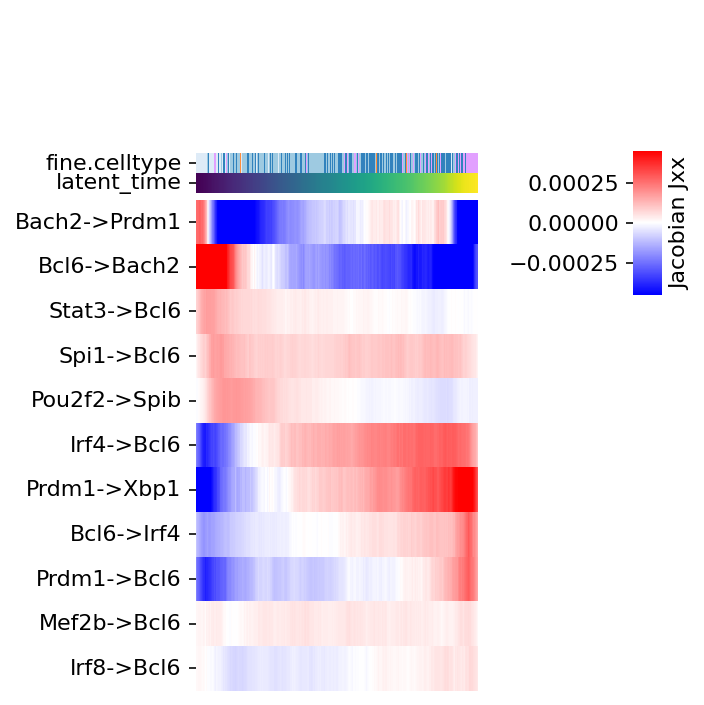

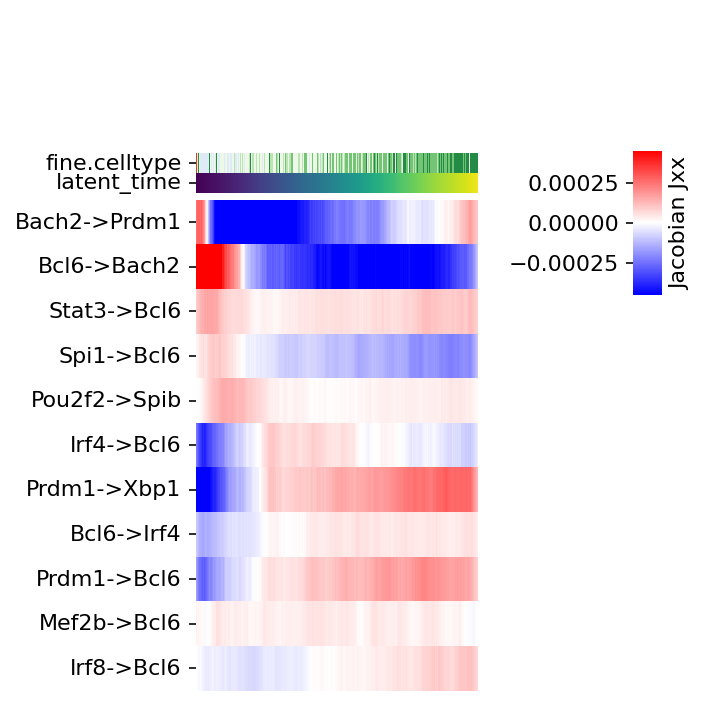

In [19]:
scv.set_figure_params(vector_friendly=True, dpi_save=300, dpi=300)
%matplotlib inline

# J_dvx_dx (for known interactions)
regulator_effector_list = [['Bcl6', 'Bach2'],
                           ['Bcl6', 'Irf4'],
                           ['Bach2', 'Prdm1'],
                           ['Prdm1', 'Bcl6'],
                           ['Prdm1', 'Xbp1'],
                           ['Irf4', 'Bcl6'],
                           ['Hhex', 'Bcl6'],
                           ['Nfkb1', 'Myc'],
                           ['Nfkb2', 'Myc'],
                           ['Myc', 'E2f1'],
                           ['Myc', 'E2f1'],
                           ['Bcl6', 'Myc'],
                           ['Stat3', 'Bcl6'],
                           ['Mef2b', 'Bcl6'],
                           ['Irf8', 'Bcl6'],
                           ['Spi1', 'Bcl6'],
                           ['Pou2f2', 'Spib'],
                            ]

n_cells = adata_rna_pred.shape[0]
n_regs = len(regulator_effector_list)
A = np.empty([n_cells,0])

columns = []
plot = True
for i, re_pair in enumerate(regulator_effector_list):
    regulator = re_pair[0]
    effector = re_pair[1]

    if (regulator in adata_rna_pred.uns['Jacobians:genes_of_interest']) and (effector in adata_rna_pred.uns['Jacobians:genes_of_interest']):

        # umap of Jacobians
        idx_regulator = np.where(adata_rna_pred.uns['Jacobians:genes_of_interest']==regulator)[0]
        idx_effector = np.where(adata_rna_pred.uns['Jacobians:genes_of_interest']==effector)[0]
        J = adata_rna_pred.obsm['J_dvx_dx'][:,idx_effector, idx_regulator].flatten()
        A = np.append(A, J.reshape([n_cells,1]), axis=1)
        adata_rna_pred.obs[f'J_dvx_dx: {regulator}->{effector}'] = J
        vmax = J.max()

        if plot:
            plt.figure(figsize=(5, 5))
            sc.pl.umap(adata_rna_pred, color=[f'J_dvx_dx: {regulator}->{effector}'], alpha=0.5, cmap='bwr', vmax=vmax, vmin=-vmax, show=False, frameon=False)
            plt.savefig(fig_dir+f'/jacobians/umaps/J_dvx_dx/'+f'J_dvx_dx: {regulator}->{effector}_WT.pdf', bbox_inches='tight')
            plt.close()

            plt.figure(figsize=(5, 5))
            sc.pl.umap(adata_rna_pred, color=[regulator], alpha=0.5, cmap='viridis', use_raw=True, show=False, frameon=False)
            plt.savefig(fig_dir+f'/jacobians/umaps/J_dvx_dx/'+f'{regulator}_RNA_expression_WT.pdf', bbox_inches='tight')
            plt.close()

            plt.figure(figsize=(5, 5))
            vmax = adata_rna_pred[:,effector].layers['vx_pred_mean'].max()
            sc.pl.umap(adata_rna_pred, color=[effector], alpha=0.5, cmap='bwr', layer='vx_pred_mean', vmax=vmax, vmin=-vmax, show=False, frameon=False)
            plt.savefig(fig_dir+f'/jacobians/umaps/J_dvx_dx/'+f'{effector}_RNA_velocity_WT.pdf', bbox_inches='tight')
            plt.close()

            plt.figure(figsize=(5, 5))
            sc.pl.umap(adata_rna_pred, color=[effector], alpha=0.5, cmap='viridis', use_raw=True, show=False, frameon=False)
            plt.savefig(fig_dir+f'/jacobians/umaps/J_dvx_dx/'+f'{effector}_RNA_expression_WT.pdf', bbox_inches='tight')
            plt.close()

        columns.append(f'{regulator}->{effector}')

# plot dynamic GRN / PM
df = pd.DataFrame(A, index=adata_rna_pred.obs_names, columns=columns)
data = df.loc[adata_rna_pred_PM.obs_names]
annotations = adata_rna_pred_PM.obs[['fine.celltype', 'latent_time']]
annotations['fine.celltype_str'] = annotations['fine.celltype'].astype(str)

celltype_palette = sns.color_palette(adata_rna_pred_PM.uns['fine.celltype_colors'])
celltype_dict = dict(zip(adata_rna_pred_PM.obs['fine.celltype'].cat.categories, celltype_palette))
celltype_colors = annotations['fine.celltype_str'].map(celltype_dict)

norm = mcolors.Normalize(vmin=annotations['latent_time'].min(), vmax=annotations['latent_time'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
latent_time_colors = annotations['latent_time'].map(lambda x: mcolors.to_hex(sm.to_rgba(x)))

row_colors = pd.DataFrame({
    'fine.celltype': celltype_colors,
    'latent_time': latent_time_colors
})

annotations_sorted = annotations.sort_values(by=['latent_time'])
data_sorted = data.loc[annotations_sorted.index].transpose()

smooth = True
N_smooth = 200
if smooth:
    data_smooth = data_sorted.values.copy()
    for r in range(data_smooth.shape[0]):
        data_smooth[r] = np.convolve(data_smooth[r], np.ones(N_smooth)/N_smooth, mode='same')
    data_sorted.loc[:] = data_smooth

# idx = np.argsort(data_sorted.values.argmax(1))
# data_sorted = data_sorted.iloc[idx]
# regs_to_plot = data_sorted.index

regs_to_plot = ['Bach2->Prdm1', 'Bcl6->Bach2', 'Stat3->Bcl6',
                'Spi1->Bcl6', 'Pou2f2->Spib', 'Irf4->Bcl6', 
                'Prdm1->Xbp1', 'Bcl6->Irf4', 'Prdm1->Bcl6',
                'Mef2b->Bcl6', 'Irf8->Bcl6']
data_sorted = data_sorted.loc[regs_to_plot]

vmax = np.quantile(np.abs(data_sorted.values.flatten()), .95)
g = sns.clustermap(
    data_sorted,
    row_cluster=False,
    col_cluster=False,
    col_colors=row_colors,
    cmap='bwr',
    xticklabels=False,
    center=0,
    vmax=vmax,
    vmin=-vmax,
    cbar_pos=(0.92, 0.58, 0.05, 0.2),
    figsize=(4, 5),
    rasterized=True
)
g.cax.set_ylabel('Jacobian Jxx')
g.tick_params(left=True, labelleft=True, right=False, labelright=False, labelrotation=0)
plt.show()
plt.savefig(fig_dir+f'/jacobians/J_dvx_dx_known_regulations_WT_PM.pdf', bbox_inches="tight")
plt.close()

# plot dynamic GRN / CB
df = pd.DataFrame(A, index=adata_rna_pred.obs_names, columns=columns)
data = df.loc[adata_rna_pred_CB.obs_names]
annotations = adata_rna_pred_CB.obs[['fine.celltype', 'latent_time']]
annotations['fine.celltype_str'] = annotations['fine.celltype'].astype(str)

celltype_palette = sns.color_palette(adata_rna_pred_CB.uns['fine.celltype_colors'])
celltype_dict = dict(zip(adata_rna_pred_CB.obs['fine.celltype'].cat.categories, celltype_palette))
celltype_colors = annotations['fine.celltype_str'].map(celltype_dict)

norm = mcolors.Normalize(vmin=annotations['latent_time'].min(), vmax=annotations['latent_time'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
latent_time_colors = annotations['latent_time'].map(lambda x: mcolors.to_hex(sm.to_rgba(x)))

row_colors = pd.DataFrame({
    'fine.celltype': celltype_colors,
    'latent_time': latent_time_colors
})

annotations_sorted = annotations.sort_values(by=['latent_time'])
data_sorted = data.loc[annotations_sorted.index].transpose()

smooth = True
N_smooth = 200
if smooth:
    data_smooth = data_sorted.values.copy()
    for r in range(data_smooth.shape[0]):
        data_smooth[r] = np.convolve(data_smooth[r], np.ones(N_smooth)/N_smooth, mode='same')
    data_sorted.loc[:] = data_smooth

data_sorted = data_sorted.loc[regs_to_plot]

g = sns.clustermap(
    data_sorted,
    row_cluster=False,
    col_cluster=False,
    col_colors=row_colors,
    cmap='bwr',
    xticklabels=False,
    center=0,
    vmax=vmax,
    vmin=-vmax,
    cbar_pos=(0.92, 0.58, 0.05, 0.2),
    figsize=(4, 5),
    rasterized=True
)
g.cax.set_ylabel('Jacobian Jxx')
g.tick_params(left=True, labelleft=True, right=False, labelright=False, labelrotation=0)
plt.show()
plt.savefig(fig_dir+f'/jacobians/J_dvx_dx_known_regulations_WT_CB.pdf', bbox_inches="tight")
plt.close()

#### Fig. 5B, 5C

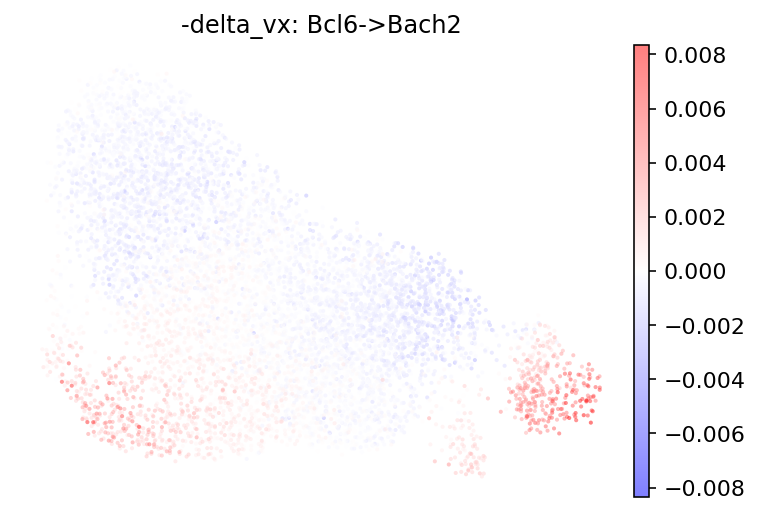

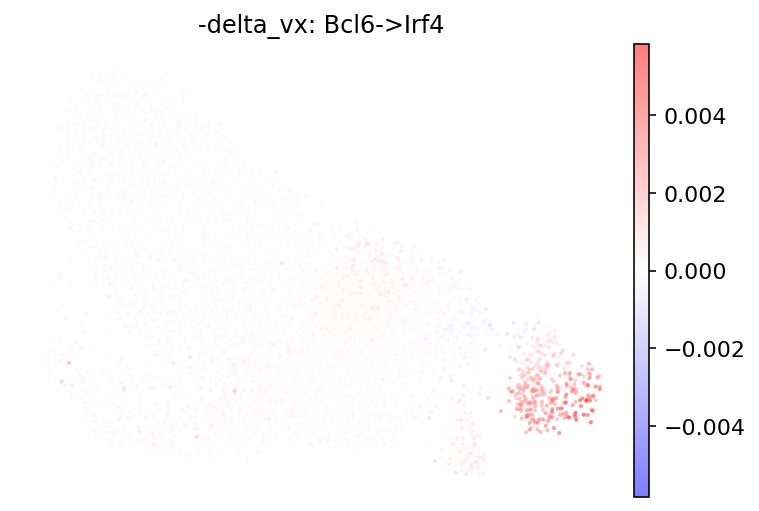

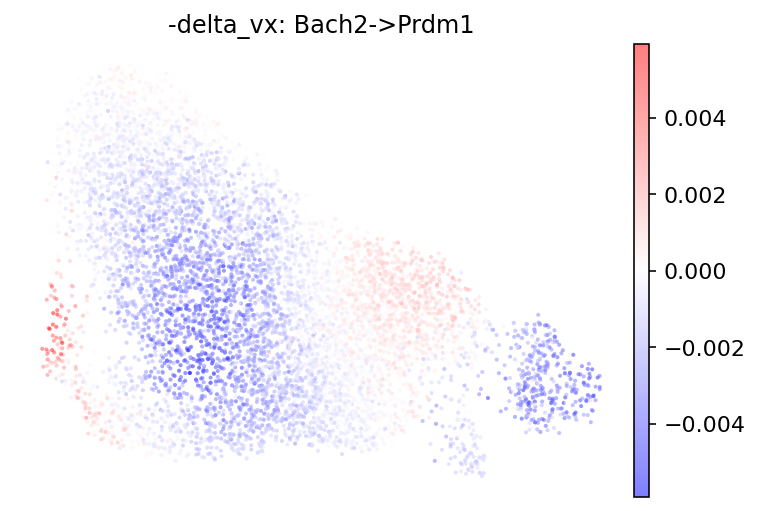

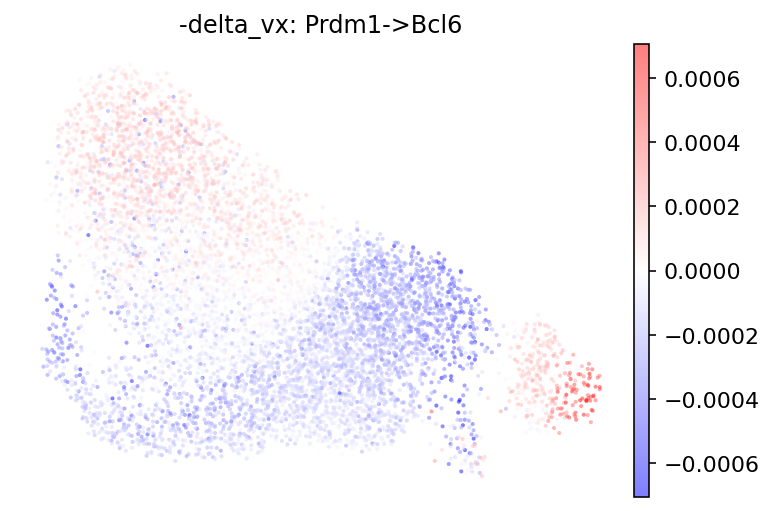

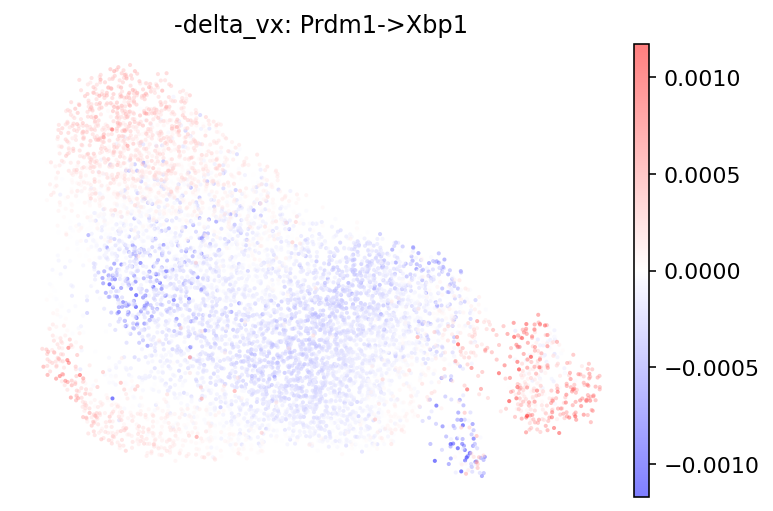

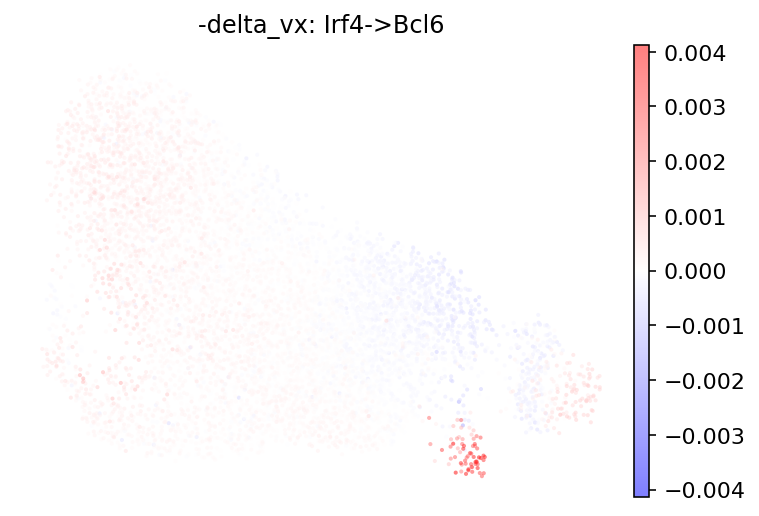

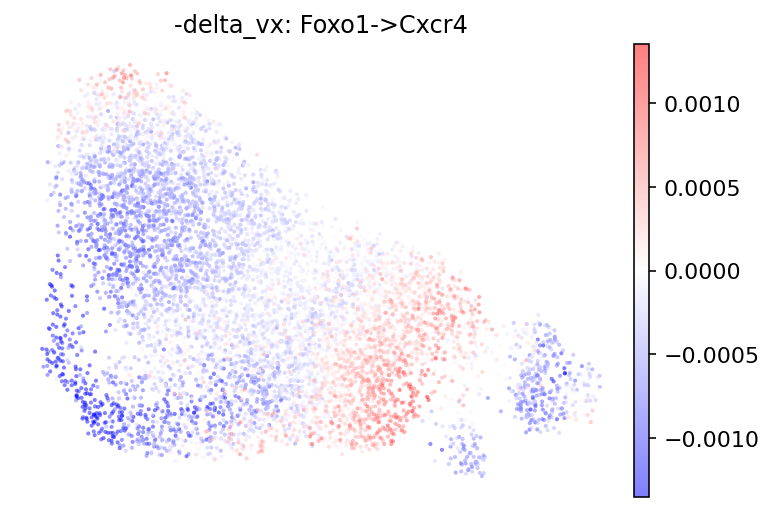

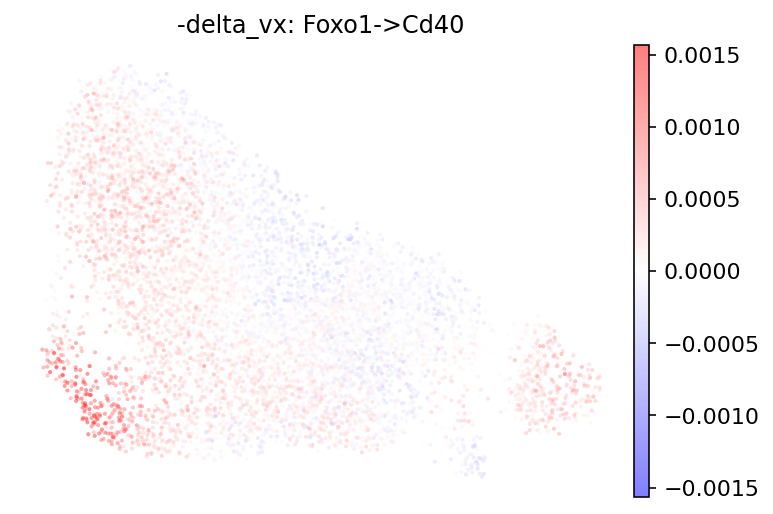

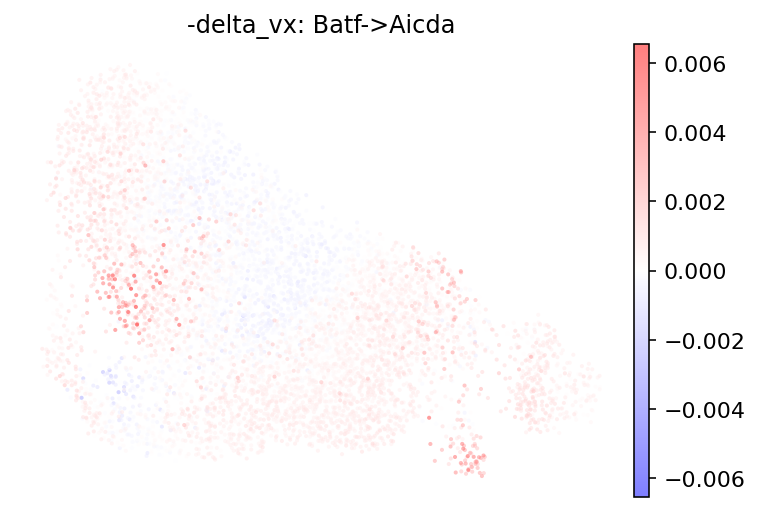

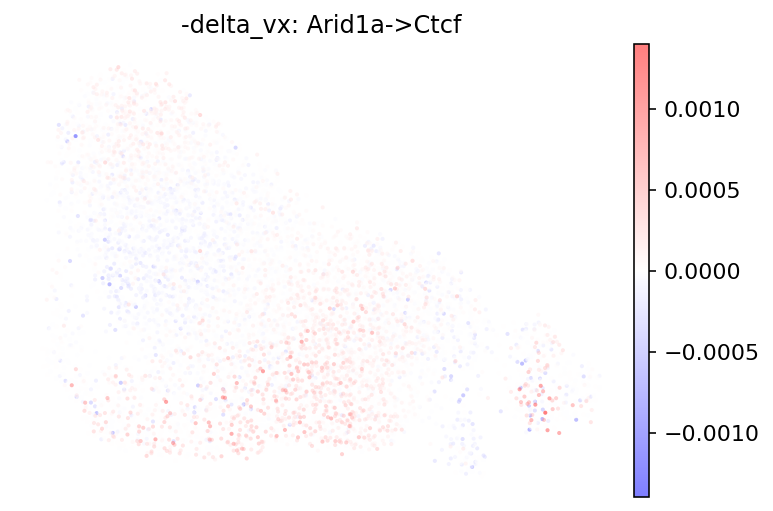

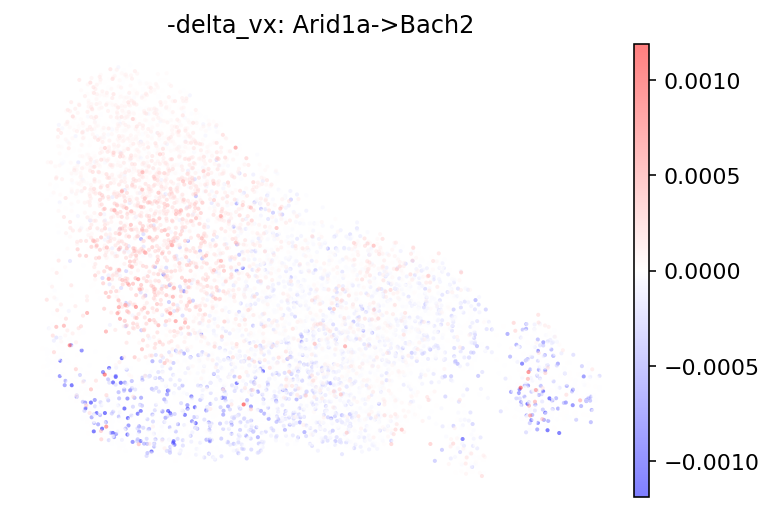

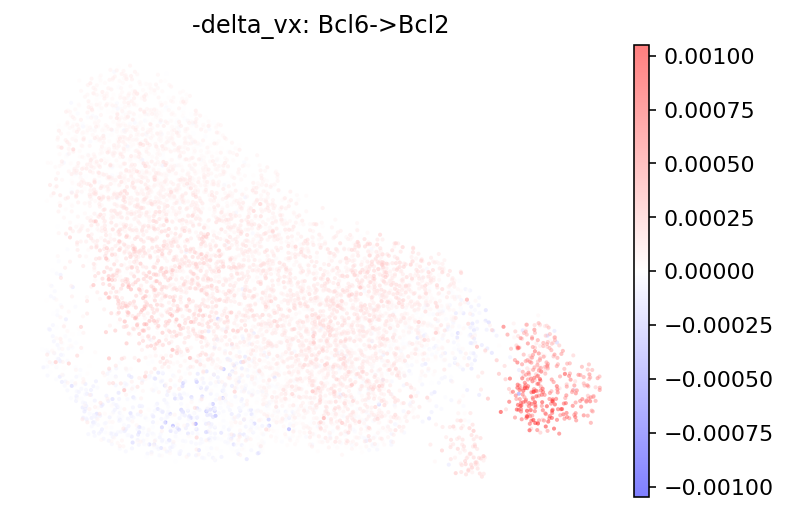

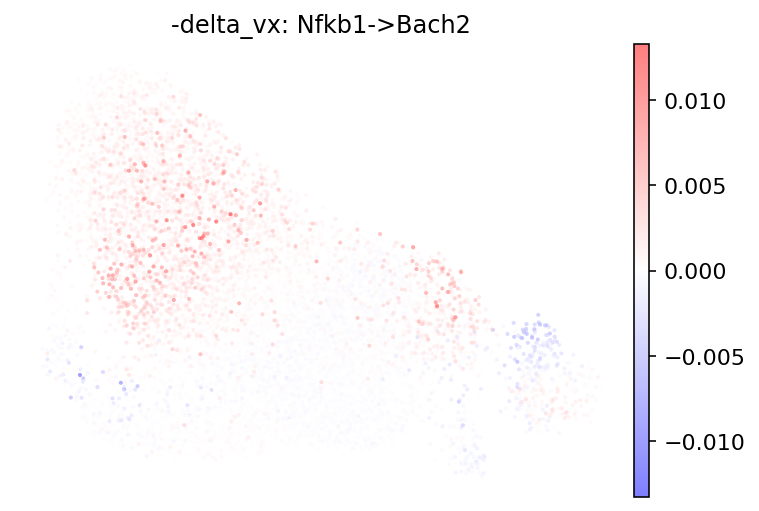

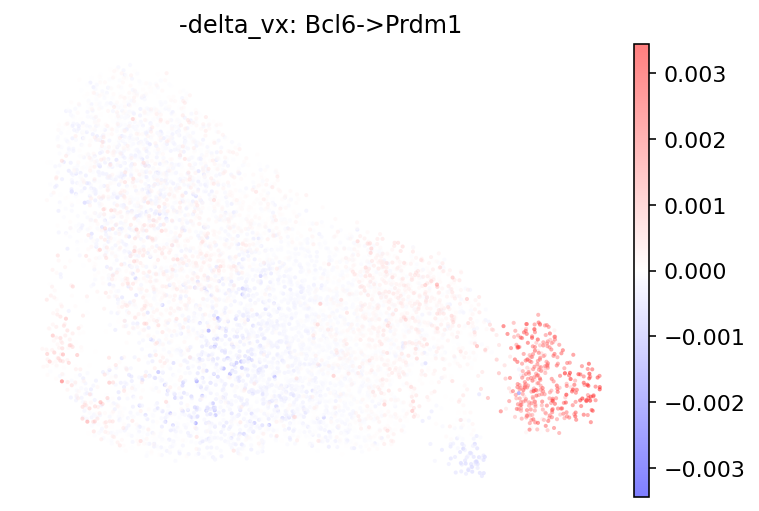

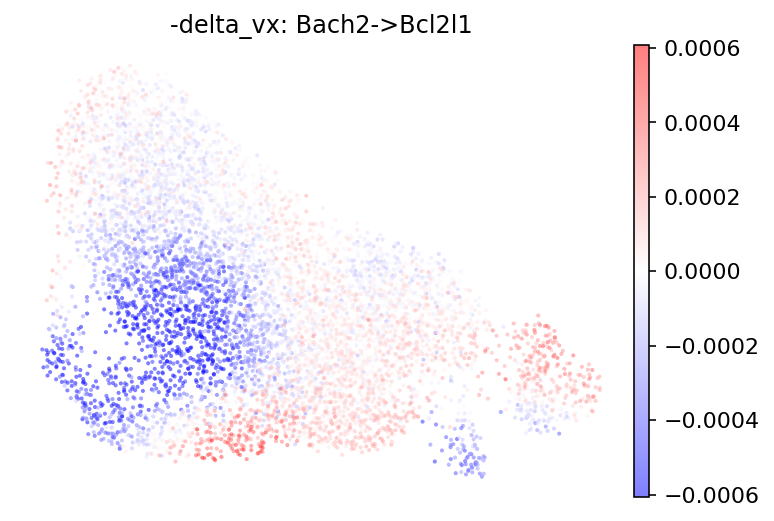

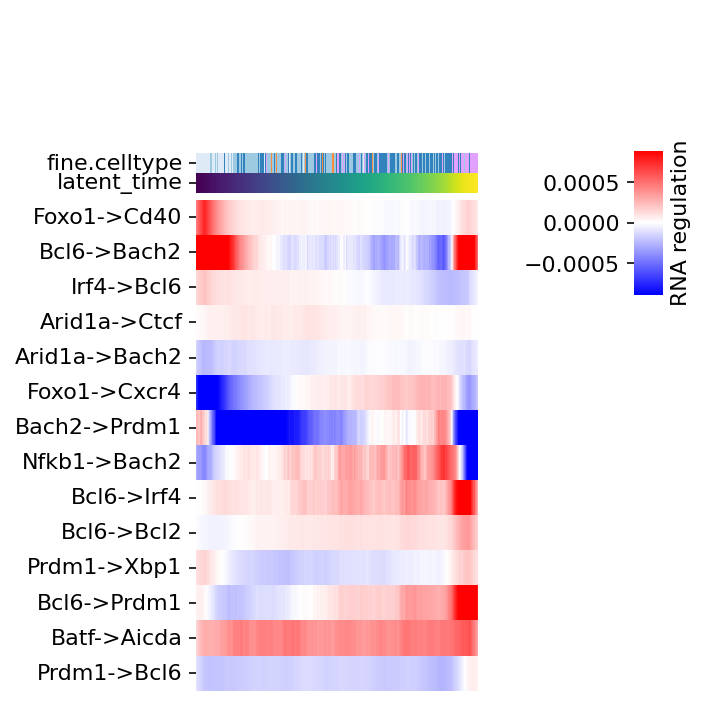

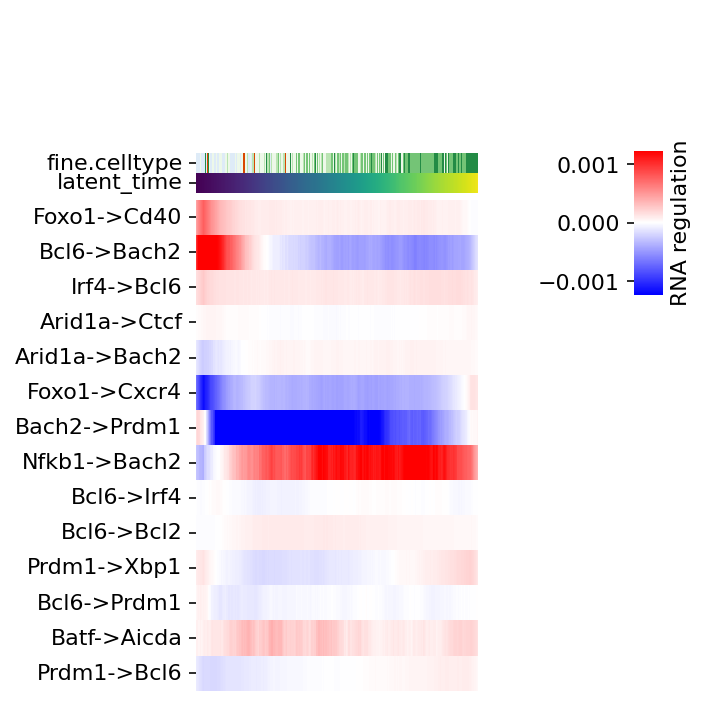

In [28]:
%matplotlib inline

# Delta vx (for known interactions)
regulator_effector_list = [['Bcl6', 'Bach2'],
                           ['Bcl6', 'Irf4'],
                           ['Bach2', 'Prdm1'],
                           ['Prdm1', 'Bcl6'],
                           ['Prdm1', 'Xbp1'],
                           ['Irf4', 'Bcl6'],
                           ['Hhex', 'Bcl6'],
                           ['Bcl6', 'Hhex'],
                           ['Nfkb1', 'Myc'],
                           ['Nfkb2', 'Myc'],
                           ['Foxo1', 'Cxcr4'],
                           ['Foxo1', 'Cd40'],
                           ['Batf', 'Aicda'],
                           ['Nfkb2', 'Icosl'],
                           ['Relb', 'Icosl'],
                           ['Arid1a', 'Ctcf'],
                           ['Arid1a', 'Bach2'],
                           ['Bcl6', 'Bcl2'],
                           ['Nfkb1', 'Bach2'],
                           ['Nfkb2', 'Bach2'],
                           ['Bcl6', 'Prdm1'],
                           ['Bach2', 'Bcl2l1'],
                            ]

n_cells = adata_rna_pred.shape[0]
n_regs = len(regulator_effector_list)
A = np.empty([n_cells,0])

columns = []
plot = True
for i, re_pair in enumerate(regulator_effector_list):
    regulator = re_pair[0]
    effector = re_pair[1]

    if (regulator in adata_rna_pred.uns['Perturbed_genes']) and (effector in adata_rna_pred.var_names):

        # umap of Jacobians
        idx_regulator = np.where(adata_rna_pred.uns['Perturbed_genes']==regulator)[0]
        idx_effector = np.where(adata_rna_pred.var_names==effector)[0]
        J = -adata_rna_pred.obsm['delta_vx'][:,idx_effector, idx_regulator].flatten()
        A = np.append(A, J.reshape([n_cells,1]), axis=1)
        adata_rna_pred.obs[f'-delta_vx: {regulator}->{effector}'] = J
        vmax = J.max()

        if plot:
            sc.pl.umap(adata_rna_pred, color=[f'-delta_vx: {regulator}->{effector}'], alpha=0.5, cmap='bwr', vcenter=0, vmax=vmax, vmin=-vmax, show=False, frameon=False)
            plt.savefig(fig_dir+f'/jacobians/umaps/delta_vx/'+f'-delta_vx: {regulator}->{effector}_WT.pdf', bbox_inches='tight')

        columns.append(f'{regulator}->{effector}')

# plot dynamic GRN / PM
df = pd.DataFrame(A, index=adata_rna_pred.obs_names, columns=columns)
data = df.loc[adata_rna_pred_PM.obs_names]
annotations = adata_rna_pred_PM.obs[['fine.celltype', 'latent_time']]
annotations['fine.celltype_str'] = annotations['fine.celltype'].astype(str)

celltype_palette = sns.color_palette(adata_rna_pred_PM.uns['fine.celltype_colors'])
celltype_dict = dict(zip(adata_rna_pred_PM.obs['fine.celltype'].cat.categories, celltype_palette))
celltype_colors = annotations['fine.celltype_str'].map(celltype_dict)

norm = mcolors.Normalize(vmin=annotations['latent_time'].min(), vmax=annotations['latent_time'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
latent_time_colors = annotations['latent_time'].map(lambda x: mcolors.to_hex(sm.to_rgba(x)))

row_colors = pd.DataFrame({
    'fine.celltype': celltype_colors,
    'latent_time': latent_time_colors
})

annotations_sorted = annotations.sort_values(by=['latent_time'])
data_sorted = data.loc[annotations_sorted.index].transpose()

smooth = True
N_smooth = 200
if smooth:
    data_smooth = data_sorted.values.copy()
    for r in range(data_smooth.shape[0]):
        data_smooth[r] = np.convolve(data_smooth[r], np.ones(N_smooth)/N_smooth, mode='same')
    data_sorted.loc[:] = data_smooth

# idx = np.argsort(data_sorted.values.argmax(1))
# data_sorted = data_sorted.iloc[idx]
# regs_to_plot = data_sorted.index

regs_to_plot = ['Foxo1->Cd40', 'Bcl6->Bach2', 'Irf4->Bcl6', 'Arid1a->Ctcf',
                'Arid1a->Bach2', 'Foxo1->Cxcr4', 'Bach2->Prdm1', 'Nfkb1->Bach2',
                'Bcl6->Irf4', 'Bcl6->Bcl2', 'Prdm1->Xbp1', 'Bcl6->Prdm1',
                'Batf->Aicda', 'Prdm1->Bcl6']
data_sorted = data_sorted.loc[regs_to_plot]

vmax = np.quantile(np.abs(data_sorted.values.flatten()), .95)
g = sns.clustermap(
    data_sorted,
    row_cluster=False,
    col_cluster=False,
    col_colors=row_colors,
    cmap='bwr',
    xticklabels=False,
    center=0,
    vmax=vmax,
    vmin=-vmax,
    cbar_pos=(0.92, 0.58, 0.05, 0.2),
    figsize=(4, 5),
    rasterized=True
)
g.cax.set_ylabel('RNA regulation')
g.tick_params(left=True, labelleft=True, right=False, labelright=False, labelrotation=0)
plt.show()
plt.savefig(fig_dir+f'/jacobians/delta_vx_known_regulations_PM_WT.pdf', bbox_inches="tight")
plt.close()

# plot dynamic GRN / CB
df = pd.DataFrame(A, index=adata_rna_pred.obs_names, columns=columns)
data = df.loc[adata_rna_pred_CB.obs_names]
annotations = adata_rna_pred_CB.obs[['fine.celltype', 'latent_time']]
annotations['fine.celltype_str'] = annotations['fine.celltype'].astype(str)

celltype_palette = sns.color_palette(adata_rna_pred_CB.uns['fine.celltype_colors'])
celltype_dict = dict(zip(adata_rna_pred_CB.obs['fine.celltype'].cat.categories, celltype_palette))
celltype_colors = annotations['fine.celltype_str'].map(celltype_dict)

norm = mcolors.Normalize(vmin=annotations['latent_time'].min(), vmax=annotations['latent_time'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
latent_time_colors = annotations['latent_time'].map(lambda x: mcolors.to_hex(sm.to_rgba(x)))

row_colors = pd.DataFrame({
    'fine.celltype': celltype_colors,
    'latent_time': latent_time_colors
})

annotations_sorted = annotations.sort_values(by=['latent_time'])
data_sorted = data.loc[annotations_sorted.index].transpose()

smooth = True
N_smooth = 200
if smooth:
    data_smooth = data_sorted.values.copy()
    for r in range(data_smooth.shape[0]):
        data_smooth[r] = np.convolve(data_smooth[r], np.ones(N_smooth)/N_smooth, mode='same')
    data_sorted.loc[:] = data_smooth

data_sorted = data_sorted.loc[regs_to_plot]
vmax = np.quantile(np.abs(data_sorted.values.flatten()), .95)
g = sns.clustermap(
    data_sorted,
    row_cluster=False,
    col_cluster=False,
    col_colors=row_colors,
    cmap='bwr',
    xticklabels=False,
    center=0,
    vmax=vmax,
    vmin=-vmax,
    cbar_pos=(0.92, 0.58, 0.05, 0.2),
    figsize=(4, 5),
    rasterized=True
)
g.cax.set_ylabel('RNA regulation')
g.tick_params(left=True, labelleft=True, right=False, labelright=False, labelrotation=0)
plt.show()
plt.savefig(fig_dir+f'/jacobians/delta_vx_known_regulations_CB_WT.pdf', bbox_inches="tight")
plt.close()